Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/")
DataSet ='dataset'
Data_dir = os.listdir(DataSet)
print(Data_dir)

Mounted at /content/drive
['with_mask', 'without_mask']


Pre-processing the images and One hot encoding


In [ ]:
#importing Required libraries
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

#Defining the Dimensions of images
img_rows, img_cols = 112 , 112

 #Defining Empty List images[] and labels[] 
 #images[] will store all images ones all resizing and grayscaling is performed.
 #labels[] stores the classes of image, i.e: With mask and without Mask.
images = []
labels = []

#Data Preprocessing to convert Images to Grayscale and separate out labels and Images
# This for loop iterate over folder (With_Mask and Without_Mask folder) 
for category in Data_dir:
  folder_path = os.path.join(DataSet, category)
  for img in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img)
    img=cv2.imread(img_path)

    try:
      grayscale_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
      resized_img = cv2.resize(grayscale_img,(img_rows, img_cols))
       # inserting processed images into images list and its type into labels list
      images.append(resized_img)
      labels.append(category)
    except Exception as e:
      print("Exception:",e)


images = np.array(images, dtype="float32")/255.0
labels = np.array(labels)
images = np.reshape(images,(images.shape[0],img_rows, img_cols,1))

# Performs one hot encoding on the labels since labels are in textual forms
# Creating the instance of LabelBinarizer

lb = LabelBinarizer()

# fit_transform() will convert text into numerical value
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(train_x, test_x, train_y, test_y) = train_test_split(images, labels, test_size=0.25,random_state=42)

''' #temporary Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
'''


' #temporary Data Augmentation\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\naug = ImageDataGenerator(\n\trotation_range=20,\n\tzoom_range=0.15,\n\twidth_shift_range=0.2,\n\theight_shift_range=0.2,\n\tshear_range=0.15,\n\thorizontal_flip=True,\n\tfill_mode="nearest")\n'

Building the Convolution neural network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D,AveragePooling2D

num_classes = 2
batch_size = 32

#Defining the Model for Convolutional Neural Network
model = Sequential()

model.add(Conv2D(64,(3,3),input_shape=(img_rows, img_cols, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))


print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 110, 110, 64)      640       
_________________________________________________________________
activation_25 (Activation)   (None, 110, 110, 64)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 53, 53, 128)       73856     
_________________________________________________________________
activation_26 (Activation)   (None, 53, 53, 128)       0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 24, 24, 128)     

Training the model

In [ ]:
from keras.optimizers import Adam
from sklearn.metrics import classification_report

epochs = 40
#Using the adaptive optimizer
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr=0.0001, decay=0.0001/epochs),
              metrics = ['accuracy'])

fitted_model = model.fit(
   train_x,train_y,  
	 epochs = epochs,
	validation_data=(test_x, test_y),
	validation_steps=len(test_x) // batch_size,
   validation_split=0.25
	 )

print( "[INFO] training head... ")
'''
H = model.fit(
	aug.flow(train_x, train_y, batch_size=batch_size),
	steps_per_epoch=len(train_x) // batch_size,
	validation_data=(test_x, test_y),
	validation_steps=len(test_x) // batch_size,
	epochs=epochs)'''

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(test_x, batch_size=batch_size)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(test_y.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

Epoch 1/40
76/76 [==============================] - 2s 28ms/step - loss: 0.6585 - accuracy: 0.5983 - val_loss: 0.6368 - val_accuracy: 0.5778
Epoch 2/40
76/76 [==============================] - 2s 26ms/step - loss: 0.5888 - accuracy: 0.6743 - val_loss: 0.5377 - val_accuracy: 0.7509
Epoch 3/40
76/76 [==============================] - 2s 26ms/step - loss: 0.4908 - accuracy: 0.7823 - val_loss: 0.4362 - val_accuracy: 0.8132
Epoch 4/40
76/76 [==============================] - 2s 26ms/step - loss: 0.4019 - accuracy: 0.8363 - val_loss: 0.3674 - val_accuracy: 0.8468
Epoch 5/40
76/76 [==============================] - 2s 26ms/step - loss: 0.3676 - accuracy: 0.8484 - val_loss: 0.3492 - val_accuracy: 0.8506
Epoch 6/40
76/76 [==============================] - 2s 26ms/step - loss: 0.3246 - accuracy: 0.8762 - val_loss: 0.3435 - val_accuracy: 0.8543
Epoch 7/40
76/76 [==============================] - 2s 26ms/step - loss: 0.2808 - accuracy: 0.8936 - val_loss: 0.3028 - val_accuracy: 0.8692
Epoch 8/40
76

Plot the model in the form of diagram

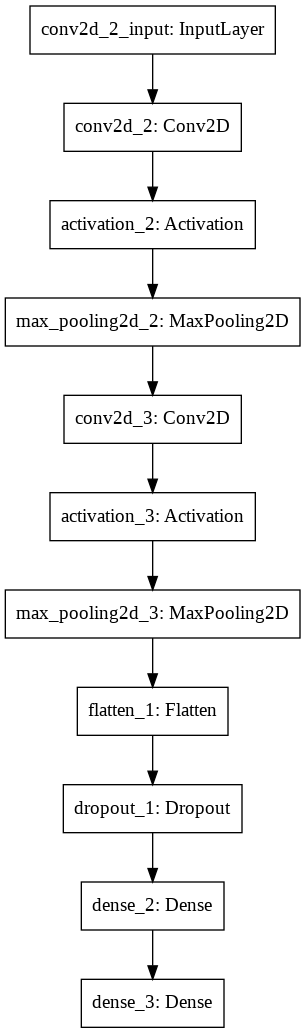

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file = "Face_mask_detection_model.png")

Plot the training loss and Accuracy of the model

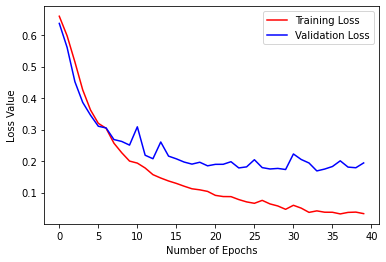

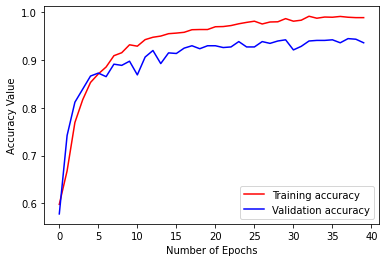

In [ ]:
from matplotlib import pyplot as plt
plt.plot( fitted_model.history['loss'],'r',label='Training Loss')
plt.plot( fitted_model.history['val_loss'],label='Validation Loss',color='blue')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

plt.plot( fitted_model.history['accuracy'],'r',label='Training accuracy')
plt.plot( fitted_model.history['val_accuracy'],label='Validation accuracy',color='blue')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()



Save the model

In [ ]:
model.save('Face_mask_detection.h5')